In [1]:
import numpy as np
import pyamg
import matplotlib.pyplot as plt

import scipy
import time

In [2]:
folder = "40"
prob = "0."+ folder 
nodes = str(16000)

In [3]:
# input_file = "data/generated_input/16384_random.txt"
# result_file = "data/generated_input/16384_random_0.85.out"

In [4]:
# !tail -10 data/generated_input/16384_random.out


In [5]:
!tail data/{folder}/ER_{prob}_{nodes}.out

0
Code is executing on device 0 
......input and copy to device done 
sink index : 15999 
eta_max is gt threshold so breaking
epoch: 100       eta_max: 0.950000       max_allowed_eta: 0.850000       beta: 1.000000          duartion: 0.0765644 sec
eta_max is gt threshold so breaking
epoch: 100       eta_max: 0.860000       max_allowed_eta: 0.850000       beta: 0.500000          duartion: 0.0615332 sec
frac_of_packet_sunk is gt threshold so breaking sink: 91813      sum: 96582      frac: 0.950612
epoch: 321850    eta_max: 0.301013       max_allowed_eta: 0.850000       beta: 0.250000          duartion: 174.772 sec


# Input File


In [6]:
input_file = "data/"+folder+"/ER_"+prob+"_"+nodes+".txt"

# Lsolve Result File

In [7]:
result_file = "data/"+folder+"/ER_"+prob+"_"+nodes+".out"

In [8]:
def read_graph(filename):
    
    file1 = open(filename, 'r')
    Lines = file1.readlines()
    file1.close()

    node_edge = Lines[0]
    node_edge = node_edge.split()
    node_edge = [int(i) for i in node_edge]
    
    row_ptr = Lines[1]
    row_ptr = row_ptr.split()
    row_ptr = [int(i) for i in row_ptr]
    
    col_off = Lines[2]
    col_off = col_off.split()
    col_off = [int(i) for i in col_off]
    
    values = Lines[3]
    values = values.split()
    values = [float(i) for i in values]
    
    b = Lines[4]
    b = b.split()
    b = [int(i) for i in b]
    
    
    return node_edge, row_ptr, col_off, values, b

# Reading the input

In [9]:
filename = input_file
node_edge, row_ptr, col_off, values, b = read_graph(filename)
dimension = len(row_ptr)-1
sink_index = [i for i in range(0, len(b)) if b[i] < 0]
assert(len(sink_index)==1) #to make sure only one elecemt is negative 
sink_index = sink_index[0]
sink_index

15999

In [10]:
def Admat_frm_CSR(row_ptr, col_off, values):
    N = len(row_ptr)-1
    A = [0]*(N*N)
    for i in range(0,len(row_ptr)-1):
        degree = row_ptr[i+1]-row_ptr[i]
        A[(N*i)+i] = degree
#         print(N,i, N*i)
        for j in range(row_ptr[i],row_ptr[i+1]):
#             print(i,j)
            A[(col_off[j])+N*(i)]= -values[j];


    A=np.asarray(A)
    A = A.reshape(N, N).T 
    return A

In [11]:
Admat_frm_CSR(row_ptr, col_off, values)

array([[ 5.648e+03, -1.000e+00, -1.000e+00, ...,  0.000e+00,  0.000e+00,
         0.000e+00],
       [-1.000e+00,  5.587e+03,  0.000e+00, ...,  0.000e+00, -1.000e+00,
         0.000e+00],
       [-1.000e+00,  0.000e+00,  5.554e+03, ...,  0.000e+00,  0.000e+00,
         0.000e+00],
       ...,
       [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  5.754e+03, -1.000e+00,
         0.000e+00],
       [ 0.000e+00, -1.000e+00,  0.000e+00, ..., -1.000e+00,  5.595e+03,
         0.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  0.000e+00,  0.000e+00,
         5.600e+03]])

In [12]:
b= np.array(b)
a = scipy.sparse.csr_matrix(Admat_frm_CSR(row_ptr, col_off, values))


# convert RHS from b to \betaJ

In [13]:
beta = 0.25
b_sink = b[-1]

In [14]:
b_new = (b*beta)/(-b_sink)
b_new[-1] # should be -beta

-0.25

# Error calculation of Lsolve

In [15]:
x_lsolve = np.loadtxt(result_file,  max_rows=node_edge[0], skiprows=0, dtype='double')
print(x_lsolve)

[5.21628e-05 5.18064e-05 5.16074e-05 ... 5.13855e-05 5.11714e-05
 0.00000e+00]


In [16]:
# x_lsolve = x_lsolve/100



Details: Lsolve 
--------------------
The residual norm is 0.12867320683595648
The relative residual norm is 0.5146285028010086


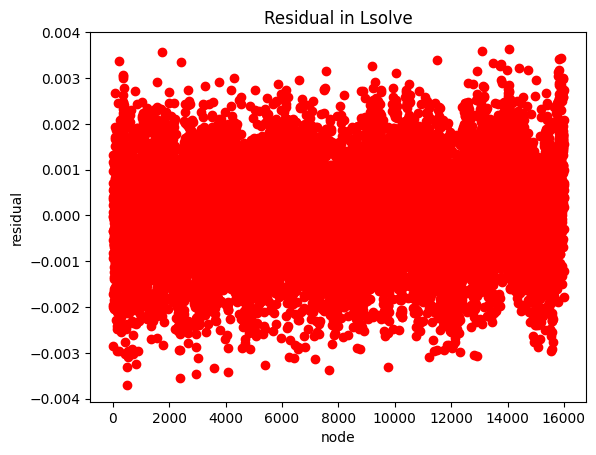

In [17]:
#residual of Lsolve

residual_lsolve =  b_new - a * x_lsolve
residual_lsolve = residual_lsolve[:-1]
plt.scatter(list(range(0, len(list(residual_lsolve)))), list(residual_lsolve), c = "red")
 
    # To show the plot
plt.xlabel("node")
plt.ylabel("residual")
plt.title("Residual in Lsolve")
print("\n")
print("Details: Lsolve ")
print("--------------------")

print("The residual norm is {}".format(np.linalg.norm(residual_lsolve)))  # compute norm of residual vector
print("The relative residual norm is {}".format(np.linalg.norm(residual_lsolve)/np.linalg.norm(b_new)))  # compute norm of residual vector

# PYAMG

In [18]:
t_ = time.time()

# ------------------------------------------------------------------
# Step 2: setup up the system using pyamg.gallery
# ------------------------------------------------------------------
n = dimension
X, Y = np.meshgrid(np.linspace(0, 1, n), np.linspace(0, 1, n))
stencil = pyamg.gallery.diffusion_stencil_2d(type='FE', epsilon=0.001, theta=np.pi / 3)

a = scipy.sparse.csr_matrix(Admat_frm_CSR(row_ptr, col_off, values))
# b = np.array(b)

res1 = []
ml = pyamg.smoothed_aggregation_solver(a)
x = ml.solve(b_new, tol=100, residuals=res1)  # solve Ax=b to a tolerance of 1e-2
#Your code here
print('Time in function', time.time() - t_)

Time in function 49.34907150268555


In [19]:
x_sink_0 = x - x[sink_index]

In [20]:
x_sink_0

array([4.46480072e-05, 4.46481761e-05, 4.46591974e-05, ...,
       4.46480690e-05, 4.46479712e-05, 0.00000000e+00])

Text(0.5, 1.0, 'x in Lx=b')

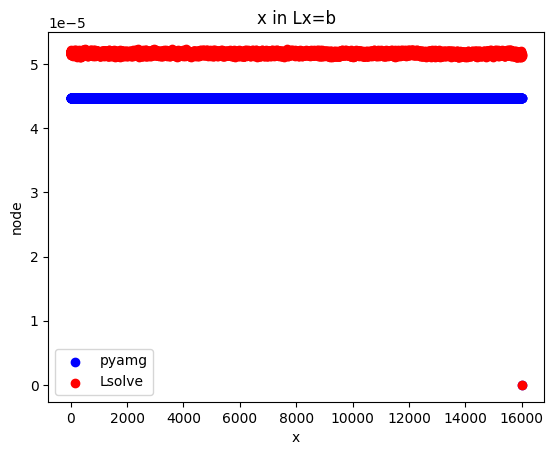

In [21]:
plt.scatter(list(range(0, len(list(x_sink_0)))), list(x_sink_0), c = "blue", label="pyamg")
plt.scatter(list(range(0, len(list(x_lsolve)))), list(x_lsolve), c = "red", label = "Lsolve")
 
    # To show the plot
plt.legend()
plt.xlabel("x")
plt.ylabel("node")
plt.title("x in Lx=b")



Details: Default AMG
--------------------
MultilevelSolver
Number of Levels:     2
Operator Complexity:  1.000
Grid Complexity:      1.000
Coarse Solver:        'pinv'
  level   unknowns     nonzeros
     0       16000     89608080 [100.00%]
     1           1            1 [0.00%]

The residual norm is 7.581289636444871e-06
The relative residual norm is 3.032136861155913e-05


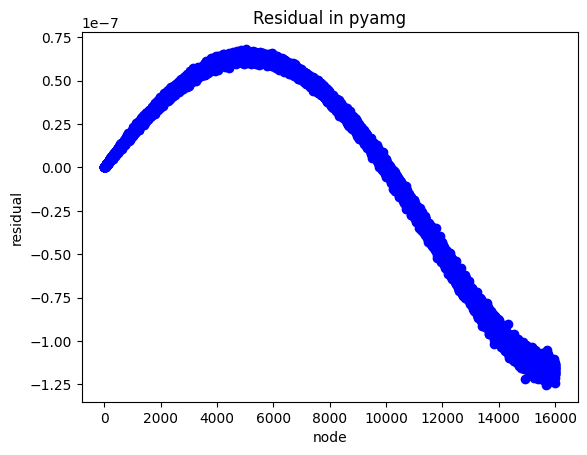

In [22]:
#residual Pyamg
residual = b_new - a * x_sink_0
# residual = residual[:-1]
plt.scatter(list(range(0, len(list(residual)))), list(residual), c = "blue")
 
    # To show the plot
plt.xlabel("node")
plt.ylabel("residual")
plt.title("Residual in pyamg")
print("\n")
print("Details: Default AMG")
print("--------------------")
print(ml)                                 # print hierarchy information

print("The residual norm is {}".format(np.linalg.norm(residual)))  # compute norm of residual vector

print("The relative residual norm is {}".format(np.linalg.norm(residual)/np.linalg.norm(b_new)))  # compute norm of residual vector

In [23]:
print("\n")
print("The Multigrid Hierarchy")
print("-----------------------")
for l in range(len(ml.levels)):
    An = ml.levels[l].A.shape[0]
    Am = ml.levels[l].A.shape[1]
    if l == (len(ml.levels)-1):
        print(f"A_{l}: {An:>10}x{Am:<10}")
    else:
        Pn = ml.levels[l].P.shape[0]
        Pm = ml.levels[l].P.shape[1]
        print(f"A_{l}: {An:>10}x{Am:<10}   P_{l}: {Pn:>10}x{Pm:<10}")



The Multigrid Hierarchy
-----------------------
A_0:      16000x16000        P_0:      16000x1         
A_1:          1x1         


In [24]:
X, Y = np.meshgrid(np.linspace(0, 1, dimension), np.linspace(0, 1, dimension))

In [25]:
ml = pyamg.smoothed_aggregation_solver(a,  # the matrix
                                       B=X.reshape(dimension * dimension, 1),             # the representation of the near null space (this is a poor choice)
                                       BH=None,                           # the representation of the left near null space
                                       symmetry='hermitian',              # indicate that the matrix is Hermitian
                                       strength='evolution',              # change the strength of connection
                                       aggregate='standard',              # use a standard aggregation method
                                       smooth=('jacobi', {'omega': 4.0 / 3.0, 'degree': 2}),   # prolongation smoothing
                                       presmoother=('block_gauss_seidel', {'sweep': 'symmetric'}),
                                       postsmoother=('block_gauss_seidel', {'sweep': 'symmetric'}),
                                       improve_candidates=[('block_gauss_seidel',
                                                           {'sweep': 'symmetric', 'iterations': 4}), None],
                                       max_levels=10,                     # maximum number of levels
                                       max_coarse=5,                      # maximum number on a coarse level
                                       keep=False)                        # keep extra operators around in the hierarchy (memory)

ValueError: The shape of near null-space modes B is incorrect

In [ ]:
--------------------------------------------------------------------------------------

In [ ]:
# ------------------------------------------------------------------
# Step 4: solve the system
# ------------------------------------------------------------------
res1 = []
x = ml.solve(b, tol=1e-12, residuals=res1)  # solve Ax=b to a tolerance of 1e-12


In [ ]:
# ------------------------------------------------------------------
# Step 5: print details
# ------------------------------------------------------------------
print("\n")
print("Details: Default AMG")
print("--------------------")
print(ml)                                 # print hierarchy information

print("The residual norm is {}".format(np.linalg.norm(b - A * x)))  # compute norm of residual vector

In [ ]:
# notice that there are 5 (or maybe 6) levels in the hierarchy
#
# we can look at the data in each of the levels
# e.g. the multigrid components on the finest (0) level
#      A: operator on level 0
#      P: prolongation operator mapping from level 1 to level 0
#      R: restriction operator mapping from level 0 to level 1
#      B: near null-space modes for level 0
#      presmoother: presmoothing function taking arguments (A,x,b)
#      postsmoother: postsmoothing function taking arguments (A,x,b)
print("\n")
print("The Multigrid Hierarchy")
print("-----------------------")
for l in range(len(ml.levels)):
    An = ml.levels[l].A.shape[0]
    Am = ml.levels[l].A.shape[1]
    if l == (len(ml.levels)-1):
        print(f"A_{l}: {An:>10}x{Am:<10}")
    else:
        Pn = ml.levels[l].P.shape[0]
        Pm = ml.levels[l].P.shape[1]
        print(f"A_{l}: {An:>10}x{Am:<10}   P_{l}: {Pn:>10}x{Pm:<10}")

In [ ]:
# ------------------------------------------------------------------
# Step 6: change the hierarchy
# ------------------------------------------------------------------
# we can also change the details of the hierarchy
ml = pyamg.smoothed_aggregation_solver(A,  # the matrix
                                       B=X.reshape(n * n, 1),             # the representation of the near null space (this is a poor choice)
                                       BH=None,                           # the representation of the left near null space
                                       symmetry='hermitian',              # indicate that the matrix is Hermitian
                                       strength='evolution',              # change the strength of connection
                                       aggregate='standard',              # use a standard aggregation method
                                       smooth=('jacobi', {'omega': 4.0 / 3.0, 'degree': 2}),   # prolongation smoothing
                                       presmoother=('block_gauss_seidel', {'sweep': 'symmetric'}),
                                       postsmoother=('block_gauss_seidel', {'sweep': 'symmetric'}),
                                       improve_candidates=[('block_gauss_seidel',
                                                           {'sweep': 'symmetric', 'iterations': 4}), None],
                                       max_levels=10,                     # maximum number of levels
                                       max_coarse=5,                      # maximum number on a coarse level
                                       keep=False)                        # keep extra operators around in the hierarchy (memory)

In [ ]:
# ------------------------------------------------------------------
# Step 7: print details
# ------------------------------------------------------------------
res2 = []                                               # keep the residual history in the solve
x = ml.solve(b, tol=1e-12, residuals=res2)              # solve Ax=b to a tolerance of 1e-12
print("\n")
print("Details: Specialized AMG")
print("------------------------")
print(ml)                                               # print hierarchy information
print("The residual norm is {}".format(np.linalg.norm(b - A * x)))  # compute norm of residual vector
print("\n")

In [ ]:
# ------------------------------------------------------------------
# Step 8: plot convergence history
# ------------------------------------------------------------------
fig, ax = plt.subplots()
ax.semilogy(res1, label='Default AMG solver')
ax.semilogy(res2, label='Specialized AMG solver')
ax.set_xlabel('Iteration')
ax.set_ylabel('Relative Residual')
ax.grid(True)
plt.legend()

figname = f'./output/amg_convergence.png'
import sys
if '--savefig' in sys.argv:
    plt.savefig(figname, bbox_inches='tight', dpi=150)
else:
    plt.show()